In [1]:
import h5py
import numpy as np
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, 
                                    MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.initializers import *
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Helper tools
i)      Helper tools are separately written functions for reducing the clutter of the main code.    
ii)     Helper tools are written for input processing and visualization.    
iii)    The functions have comments about how they work 

In [2]:
from helper.io_tools import get_files, load_data
from helper.viz_tools import plot_history, plot_confusion_matrix,plot_train_images,plot_test_images,plot_incorrect

# Get data label and encoding 

In [3]:
train_df,test_df,val_df,alternate_df,subset_labels=get_files()

# Load the dataframe and get array and label combo

In [4]:
train_images,train_labels=load_data(train_df)
val_images,val_labels=load_data(val_df)
test_images,test_labels=load_data(test_df)

# Exploratory data analysis
Training images with labels

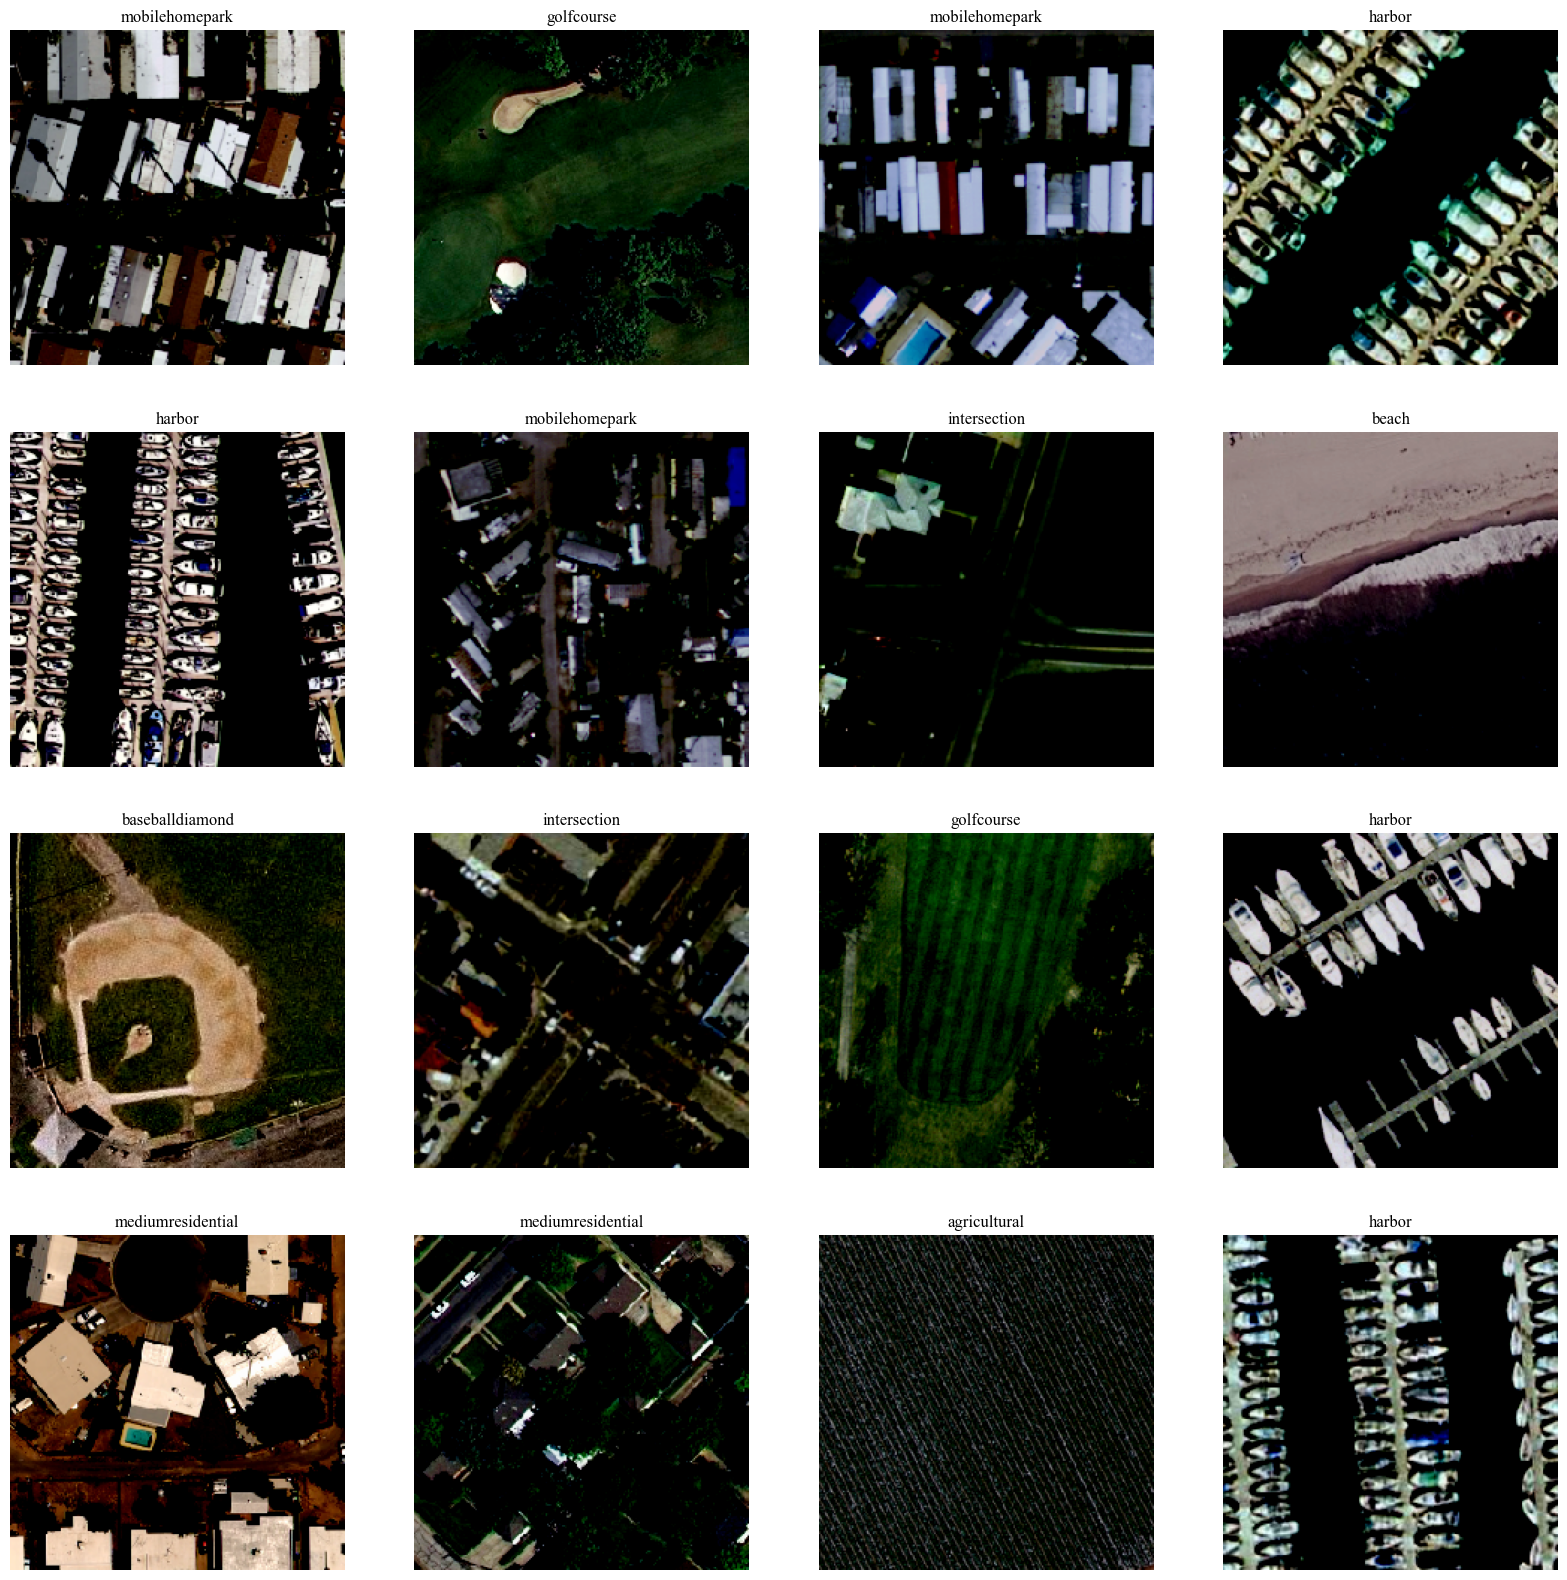

In [5]:
plot_train_images(train_images,train_labels,subset_labels)

In [6]:
print('Train Images are {} out of 1400'.format(train_labels.shape[0]))
print('Validation Images are {} out of 1400'.format(val_labels.shape[0]))
print('Test Images are {} out of 1400'.format(test_labels.shape[0]))
#  val_labels.shape,test_labels.shape

Train Images are 980 out of 1400
Validation Images are 140 out of 1400
Test Images are 280 out of 1400


## Model Architecture
MobileNet Model


In [7]:
model_1 = MobileNet(weights="imagenet",include_top=False,input_shape=(224,224,3))
for layer in model_1.layers:
    layer.trainable = False
model_1.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [8]:
num_classes = 14
headModel = model_1.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128,activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)

model_2 = Model(inputs=model_1.input, outputs=headModel)

model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

Adam optimizer with a learning rate of 0.001

In [9]:
opt_2 = Adam(lr=1e-3)
model_2.compile(loss="categorical_crossentropy",optimizer=opt_2,metrics=['accuracy'])

c:\Users\nirde\.conda\envs\dl\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# To Tensorboard

In [10]:
MobileNet_checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
MobileNet_logs = TensorBoard("MobileNet-transfer-logs")

# Model training on GPU for 30 epochs

In [11]:

batchSize = 10
epochs = 30

# with tf.device('/GPU:0'):  #use if gpu in the system
history = model_2.fit(train_images, train_labels,
                    steps_per_epoch=len(train_images)//batchSize,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(val_images,val_labels),
                    validation_steps=len(val_images)//batchSize)

Epoch 1/30
98/98 - 5s - loss: 1.2351 - accuracy: 0.6276 - val_loss: 0.2834 - val_accuracy: 0.9214 - 5s/epoch - 52ms/step
Epoch 2/30
98/98 - 1s - loss: 0.3135 - accuracy: 0.9031 - val_loss: 0.1661 - val_accuracy: 0.9571 - 1s/epoch - 13ms/step
Epoch 3/30
98/98 - 1s - loss: 0.2054 - accuracy: 0.9367 - val_loss: 0.1581 - val_accuracy: 0.9429 - 1s/epoch - 13ms/step
Epoch 4/30
98/98 - 1s - loss: 0.1154 - accuracy: 0.9684 - val_loss: 0.1659 - val_accuracy: 0.9643 - 1s/epoch - 13ms/step
Epoch 5/30
98/98 - 1s - loss: 0.0992 - accuracy: 0.9694 - val_loss: 0.1713 - val_accuracy: 0.9571 - 1s/epoch - 13ms/step
Epoch 6/30
98/98 - 1s - loss: 0.0866 - accuracy: 0.9755 - val_loss: 0.1469 - val_accuracy: 0.9571 - 1s/epoch - 13ms/step
Epoch 7/30
98/98 - 1s - loss: 0.0661 - accuracy: 0.9796 - val_loss: 0.1409 - val_accuracy: 0.9643 - 1s/epoch - 13ms/step
Epoch 8/30
98/98 - 1s - loss: 0.0443 - accuracy: 0.9867 - val_loss: 0.1436 - val_accuracy: 0.9500 - 1s/epoch - 13ms/step
Epoch 9/30
98/98 - 1s - loss: 0.

# Check for Overfit and underfit

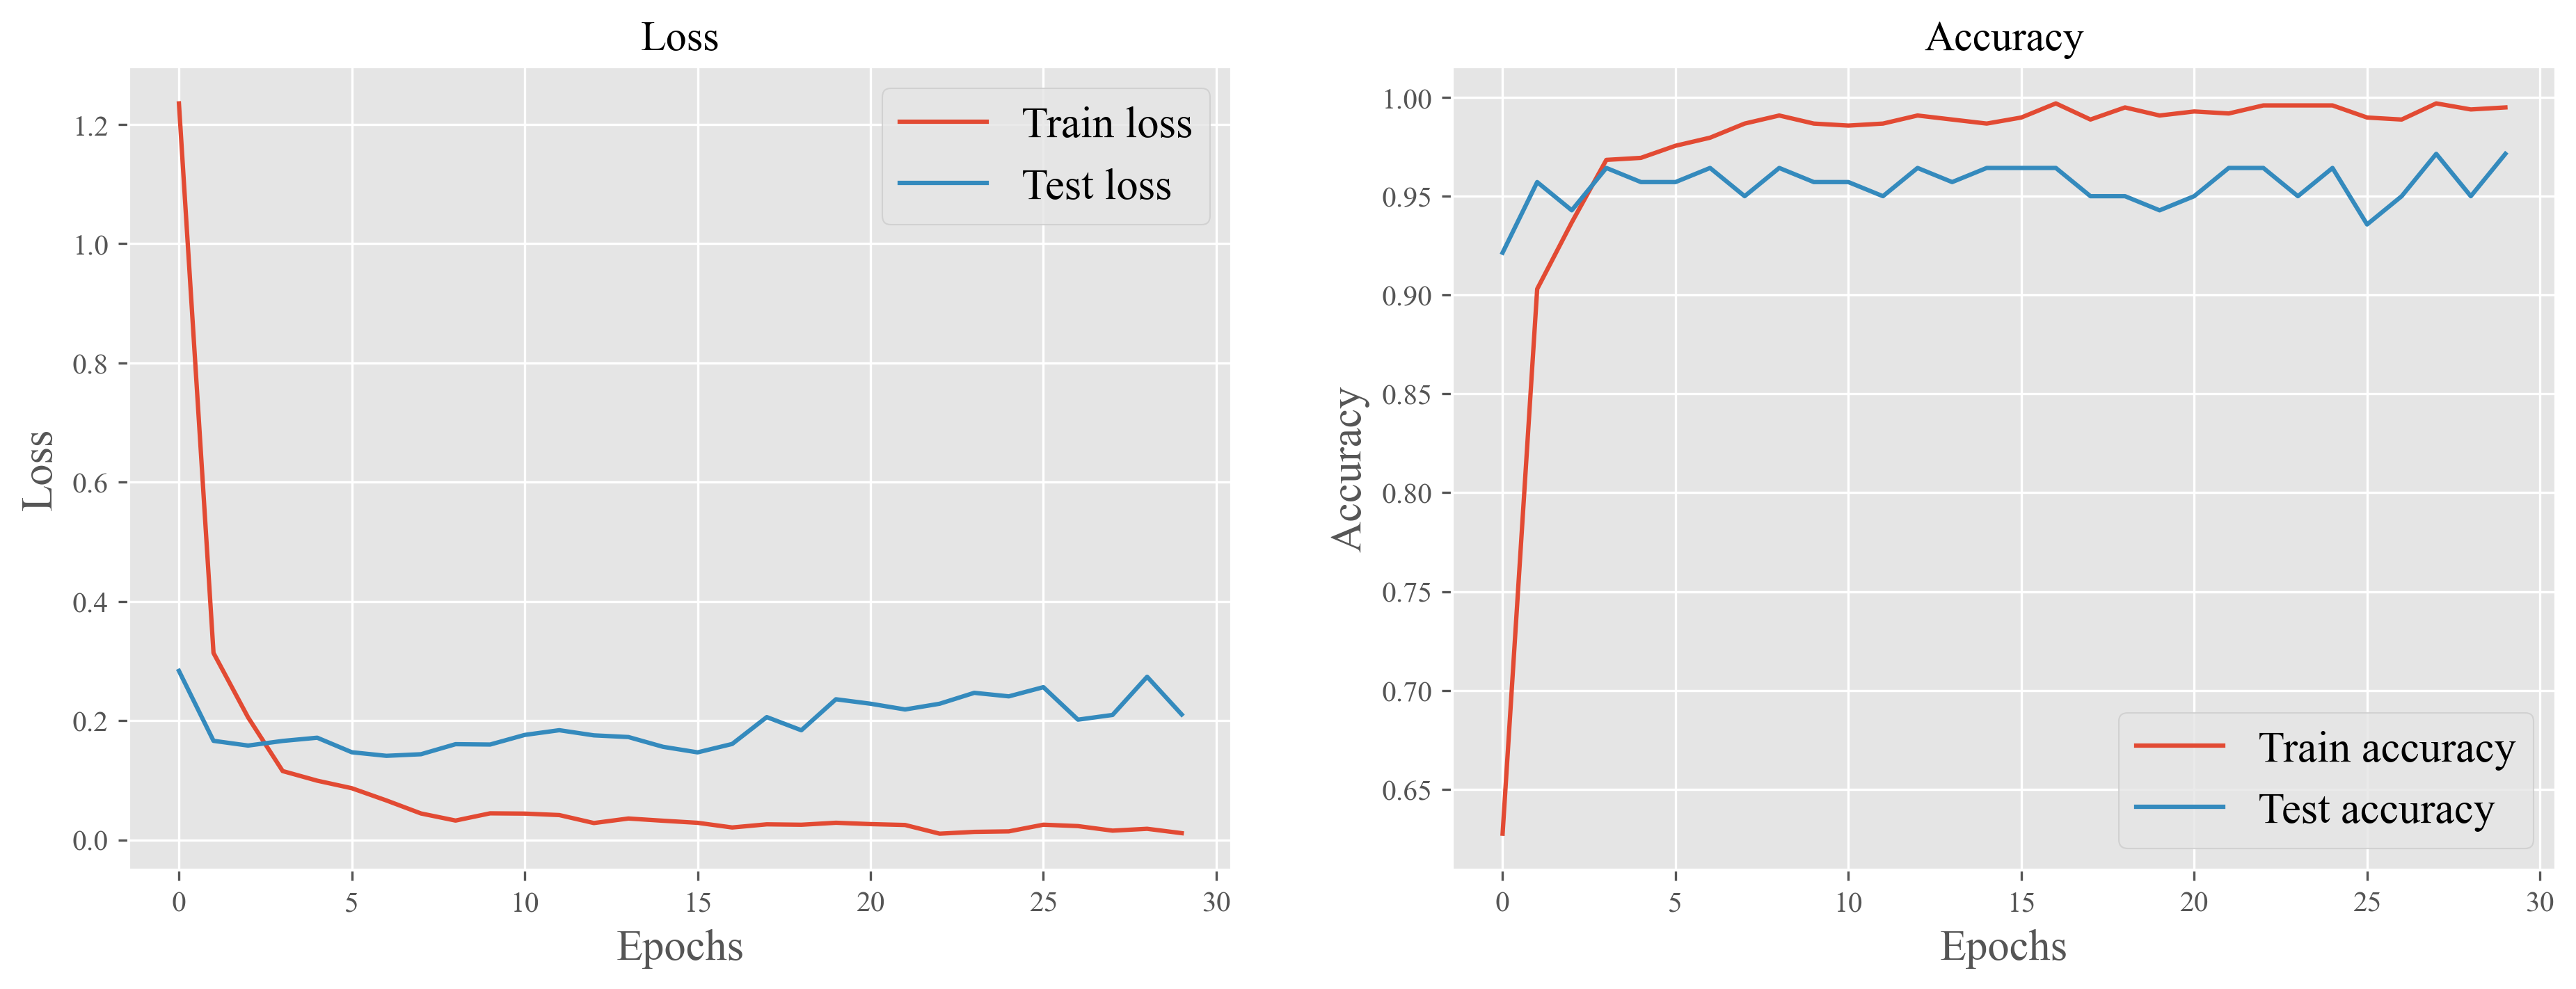

In [12]:
plot_history(history)

# Get predictions and original labels using ARGMAX

In [13]:
val_test = np.argmax(model_2.predict(test_images), axis=1)
test_actual = np.argmax(test_labels, axis=1)

9/9 [==============================] - 1s 23ms/step


# Plot confusion matrix on test data to check where model is unable to classify

In [14]:
cnf_mat = confusion_matrix(test_actual, val_test,normalize='true')
plot_confusion_matrix(cnf_mat, classes=subset_labels)

# Test Accuracy 

In [15]:
print("Test Accuracy: ", np.sum(val_test == test_actual)/len(test_actual))

Test Accuracy:  0.975


# Plot test images with true and predicted label

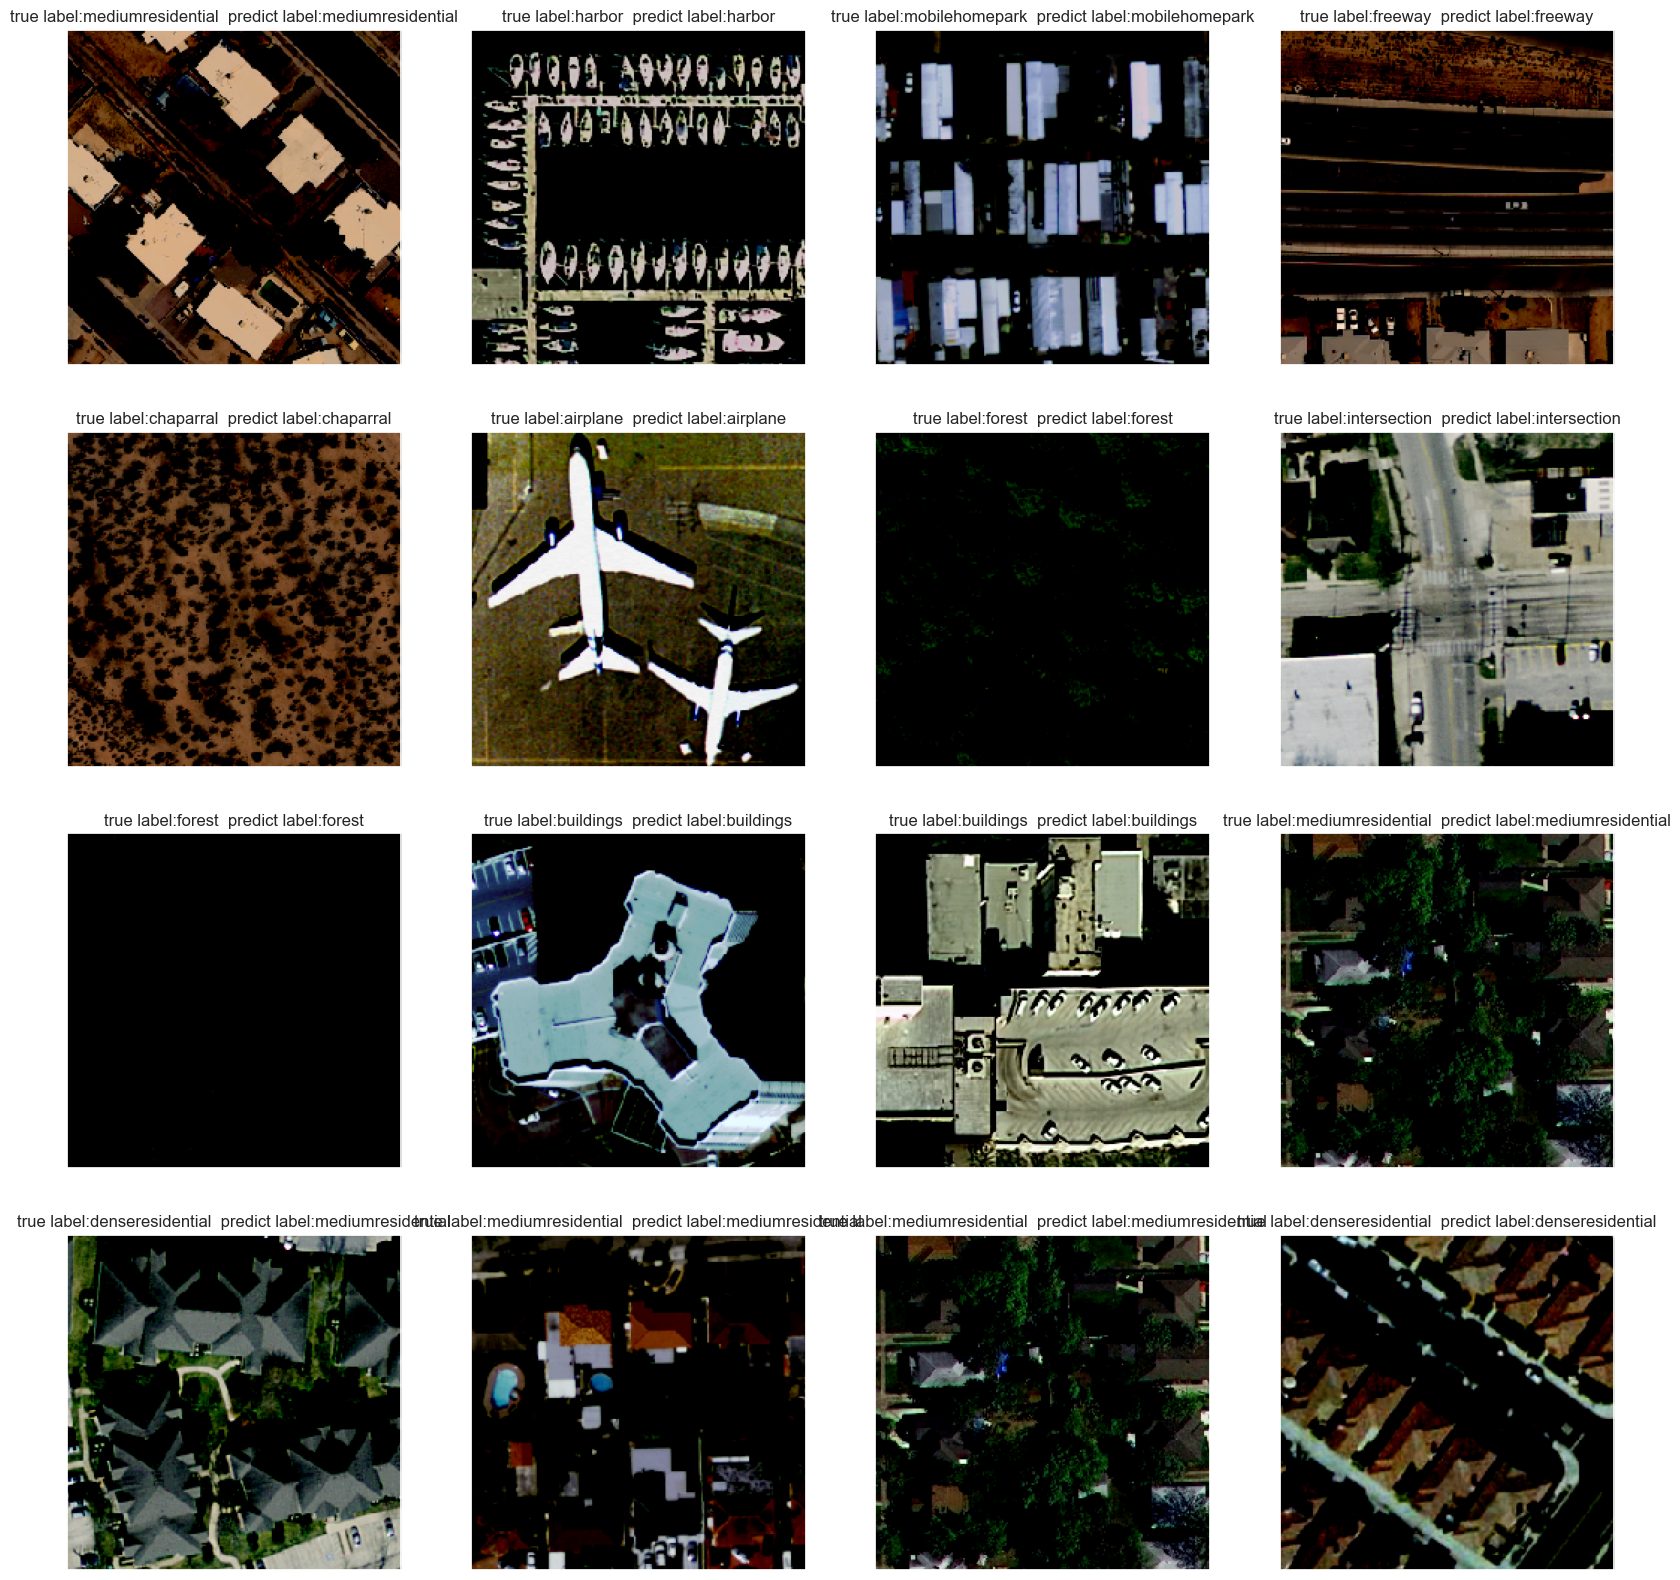

In [16]:
plot_test_images(test_images,val_test,test_actual,subset_labels)

# plot images incorrectly classified by model for model improvement

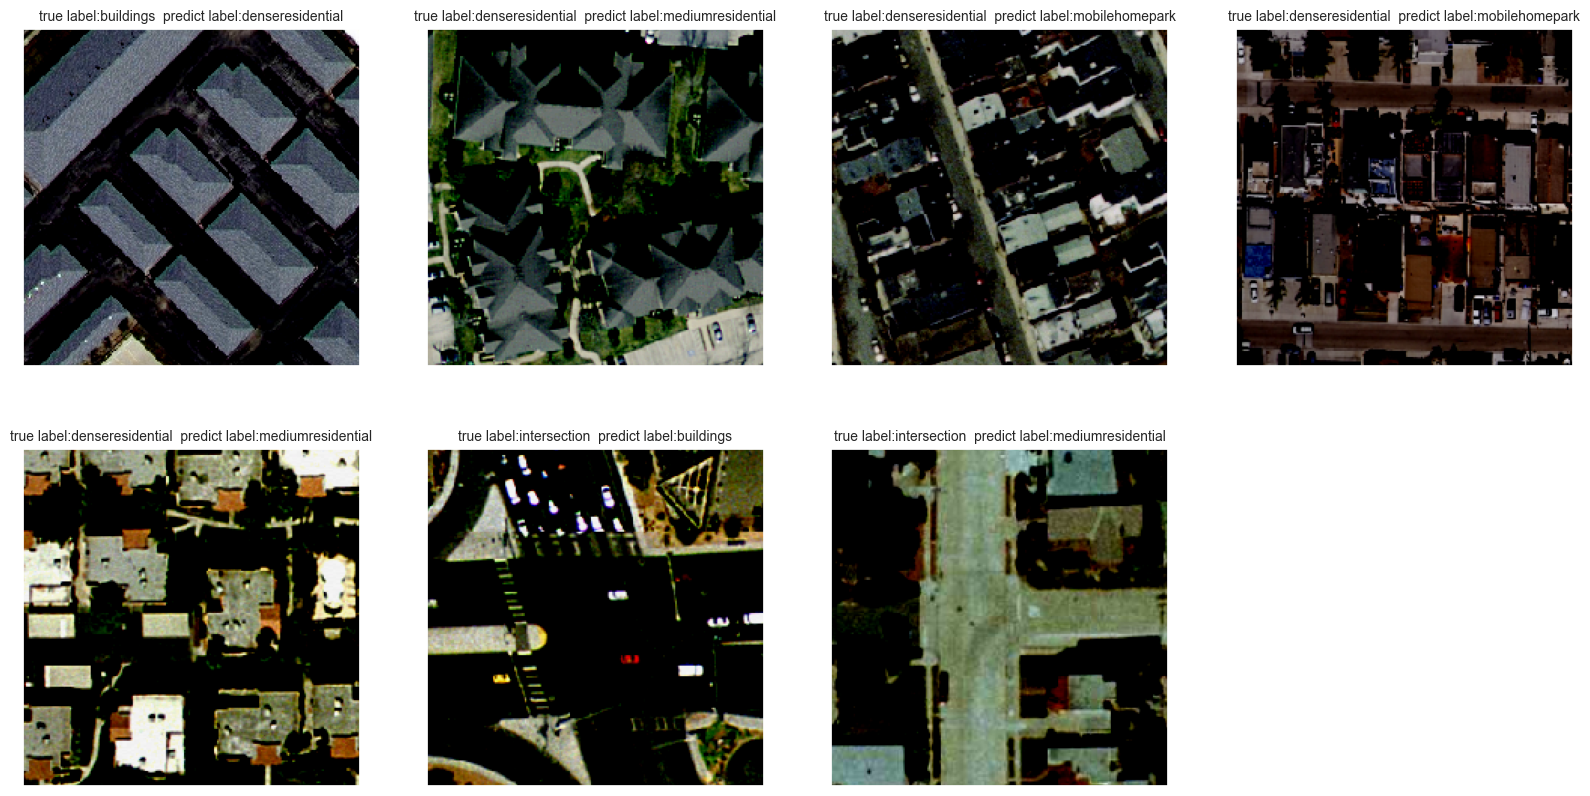

In [17]:
plot_incorrect(test_images,val_test,test_actual,subset_labels)

# As per Assignment get average max probabilty for test images 

In [18]:
print("average probability: ", np.mean(np.max(model_2.predict(test_images),axis=1)))

9/9 [==============================] - 0s 23ms/step
average probability:  0.9886931


# As per assignment get average max probability for alternate data i.e the 7 classes not included in analysis
The labels will be incorrect since the model is never trained on similar images

In [19]:
alternate_images,_=load_data(alternate_df)
print("average alternate probability: ", np.mean(np.max(model_2.predict(alternate_images),axis=1)))

22/22 [==============================] - 1s 23ms/step
average alternate probability:  0.8744258


# Conclusion
The average max probabilty for images never seen by model is 0.86 whereas for test data is 0.989

In [20]:
# model_2.save("MobileNet_transfer_model.h5")

TensorBoard  